# Multi-agent Reinforcement Learning using PettingZoo: Tic-tac-toe example part II

*Gertjan Verhoeven*

*March 2021*

## Installs

In [ ]:
!apt-get install python3.9-venv

# create venv
!python3 -m venv marl-env
# active venv
!source marl-env/bin/activate
# upgrade really old pip version on my system
!pip install --upgrade pip
# install packages
!pip install pettingzoo[classic]
!pip install spyder-notebook
!pip install dill

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.9-venv is already the newest version (3.9.9-1+bionic2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Error: Command '['/content/marl-env/bin/python3', '-Im', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: marl-env/bin/activate: No such file or directory


Having learned the basics of PettingZoo, and how to use hashing with `defaultdict` to build up a Q-table, we are ready to implement Q-learning on the tic-tac-toe environment using PettingZoo. Before we get into the coding part, first some general remarks about Q-learning in a two-player alternating turn game.

# Training multi-agent games using single agent techniques

Here we will train a multi-agent game using single agent Q-learning. This means that from the perspective of each player, the other player is part of the environment. It follows that the learned strategy of the first player is tuned to the strategy used by the second player. The second player's strategy can be thought of forming a part of the environment the first player learns to perform optimally in.

Therefore, if we use Q-learning against a player that uses a random strategy, The Q-learner optimizes for play in an evironment **that contains a player that uses a random strategy**.

Here, we let **both** players learn using Q-learning with constant learning parameter $\alpha = 0.6$, and have them use the same decreasing $\epsilon$ exploration rate. So both players start off playing randomly ($\epsilon = 1$), and after 200.000 steps end up exploiting the learned policy for 97.5% of the time.


We expect that this produces Q-tables for both players that perform well against random players and human players.


# Q-learning with two players: remembering previous states and actions

Many implementations of Q-learning for Tic-Tac-Toe play out a full game and memorize the sequence of states for both players. After a single game has ended, the "Q-learning" part is done in one go, starting from the end state en propagating back to the beginning. 

This is possible for Tic-Tac-Toe because no state is ever visited twice during a single game. However, this is not true for all games, so I think it is better to implement Q-learning in a more general way, where we learn each time the player "steps" through the game.

In single agent RL using Gym, we start in a state, make a move, end up in a new state, and collect our reward. This allowed us to use variables like `current_state` and `next_state` within a single RL iteration for the Q-learning. 

In multi-agent (two player alternating turn, to be more precise), an agent observes a state, chooses an action, THEN hands over the turn, where the other agent observes the state, and chooses an action, then control returns to the first agent, which sees the result of its previous action, and finds itself in a new state.

Thus, we need a way to store the previous state and previous action for each player to use Q-learning. We store these values in two simple dictionaries:

In [ ]:
prev_state = {'player_1': -1,
              'player_2': -1}
prev_action = {'player_1': -1,
              'player_2': -1}

I went for two independent Q-tables, and player 1 always starts first (This is how the environment works). So we will end up with two Q-tables, one for the player going first, and one for the player going second. 

# Coding Q-learning in PettingZoo step by step

In [ ]:
from pettingzoo.classic import tictactoe_v3
import random
import numpy as np
from collections import defaultdict
import dill
import matplotlib.pyplot as plt

It is advisable to have the actual Q-learning and helper functions in a separate `marl_qlearning.py` python script, which we import and run code from in Jupyter notebook, i.e.:

In [ ]:
# from marl_qlearning import *

We build on the code from the previous notebook.
We already have `encode_state()` to convert the observation into a unique state label.


In [ ]:
import hashlib

def encode_state(observation):
    # encode observation as bytes           
    obs_bytes = str(observation).encode('utf-8')
    # create md5 hash
    m = hashlib.md5(obs_bytes)
    # return hash as hex digest
    state = m.hexdigest()
    return(state)


## Exercise 1: Create epsilon_greedy_policy()

We need a function that contains the epsilon-greedy policy functionality.

Code a function `epsilon_greedy_policy()` that takes as arguments:

* `nA`, number of actions
* `Q`, the list of Q-table dictionaries for both players, indexed by agent and by state
* `agent`, the agent currently acting
* `action_mask`, containing the available actions in the current state
* `state` , the hash of the current state
* `eps`, the value of the exploration parameter epsilon

(Hint: I used `Q[agent][state][action_mask == 1]` to select the Q-values of all available actions for an agent in a state)


In [ ]:
def epsilon_greedy_policy(nA, Q, agent, action_mask, state, eps):
  if random.random() < eps:
    # action = random action from action space
    # action = random.choice(np.flatnonzero(observation['action_mask']))
    # print(agent, "chose a random action")
    action = random.choice([i for i in range(nA) if action_mask[i] == 1])
  else:
    # action = best action from Q = max_i(Q(S, i))
    # np.flatnonzero(Q[agent][state][action_mask == 1])
    action = max([i for i in range(nA) if action_mask[i] == 1], key = lambda x: Q[agent][state][x])
  return action

## Exercise 2: Create update_Q_value()

Code a function update_Q_value() that takes as arguments:

* `Q`, the list of Q-table dictionaries for both players, indexed by agent and by state
* `agent`, the agent currently acting
* `previous_state`, the hash of the previous state
* `previous_action`, the previous action
* `reward`, the reward received since the previous action
* `alpha`, the learning parameter
* `gamma`, the discounting parameter
* `current_state`, the hash value of the current state


In [ ]:
def update_Q_value(Q, agent, previous_state, previous_action, reward, alpha, gamma, current_state = None):
    # Take action A, see reward and next state S'
    # Q(S, A) += alpha * (reward + gamma * max_a(Q(S', a) - Q(S, A)))
    Q[agent][previous_state][previous_action] += alpha * (reward + gamma * max([Q[agent][current_state][x] - Q[agent][previous_state][previous_action] for x in range(len(Q[agent][current_state]))]))
    return Q

## Exercise 3: create marl_q_learning()

Finally, the main program where all the parts come together.
For this function, we built on the Pettingzoo code from the previous notebook.

Code a function `marl_q_learning()` that takes as arguments

* multi_env, a pettingzoo multi-agent environment
* num_episodes, the number of episodes to run
* alpha, the learning parameter
* gamma, the discounting parameter with default 1
* eps_start, the starting value for epsilon
* eps_decay, the decay factor for epsilon
* eps_min, the minimal value for epsilon


In [ ]:
def sma(series, length):
  return [sum(series[i-length:i])/length for i in range(len(series)) if i >= length - 1]

In [ ]:
def marl_q_learning(multi_env, num_episodes, alpha, gamma=1.0, \
                    eps_start=1.0, eps_decay=.99999, \
                        eps_min=0.025, plot=False, nbplot=100, nbplot_points=100, plot_sma_len=2, \
                    players_type={"player_1" : "Q", "player_2" : "Q"}, verbose=False):
    
    multi_env.reset()
    Q = {}
    y1=[]
    y2=[]
    for agent in multi_env.agents:    
        nA = multi_env.action_spaces[agent].n
        # print(multi_env.action_spaces[agent])
        Q[agent] = defaultdict(lambda: np.zeros(nA))
    # print("Q", Q)
    epsilon = eps_start

    i_episode = 1    

    prev_state = {'player_1': -1,
                  'player_2': -1}
    prev_action = {'player_1': -1,
                  'player_2': -1}

    # keeps iterating over active agents until num episode break
    while i_episode <= num_episodes:
        if i_episode % 1_000 == 0 and verbose:
            print("Episode", i_episode)
            # print("Q", Q)
        for agent in multi_env.agent_iter():        
            
            # get observation (state) for current agent:
            observation, reward, done, info = multi_env.last()

            # store current state
            state = encode_state(multi_env.render(mode = 'ansi'))
            
            # perform q-learning with update_Q_value()
            # your code here
            Q = update_Q_value(Q, agent, prev_state[agent], prev_action[agent], reward, alpha, gamma, current_state = state) # It should update it
            
            
            prev_state[agent] = state
            
            if not done: 
                # choose action using epsilon_greedy_policy()
                # your code here               
                if players_type[agent] == "Q":
                  action = epsilon_greedy_policy(nA, Q, agent, observation['action_mask'], state, epsilon)
                elif players_type[agent] == "random":
                  action = epsilon_greedy_policy(nA, Q, agent, observation['action_mask'], state, 1)
                else:
                  raise ValueError("Error: Unknown player type. Choose between 'Q' and 'random'")

                multi_env.step(action)
                
                # store chosen action
                prev_action[agent] = action 
            else: 
                # agent is done
                multi_env.step(None)

        # reset env and memory
        multi_env.reset()
        prev_state = {'player_1': -1,
                      'player_2': -1}
        prev_action = {'player_1': -1,
                       'player_2': -1}
        
        if(plot == True) and i_episode % (num_episodes/nbplot_points) == 0:
          outcomes = test_policy(Q, nbplot, verbose=False)
          y1.append(outcomes["player_1"])
          y2.append(outcomes["player_2"])
          # reset env and memory
          multi_env.reset()
          prev_state = {'player_1': -1,
                        'player_2': -1}
          prev_action = {'player_1': -1,
                        'player_2': -1}
          
        # bump episode
        i_episode += 1
        # decrease epsilon
        epsilon = max(epsilon*eps_decay, eps_min)

    if(plot == True):
      # plt.plot([i for i in range(1, nbplot_points)],[(y1[i] + y1[i-1])/2 for i in range(len(y1)) if i != 0]) # Moyenne mobile de longueur 2     
      # plt.plot([i for i in range(1, nbplot_points)],[(y2[i] + y2[i-1])/2 for i in range(len(y2)) if i != 0])
      len = plot_sma_len
      sma1 = sma(y1, len)
      sma2 = sma(y2, len)
      plt.plot([i * num_episodes/nbplot_points for i in range(len - 1, nbplot_points)],sma1) # Moyenne mobile de longueur len
      plt.plot([i * num_episodes/nbplot_points for i in range(len - 1, nbplot_points)],sma2)     
    return Q

# Learning the optimal policy for Tic-Tac-Toe

We run the Q-learning algorithm for 500.000 steps and use `dill` to save the Q dictionary to disk.

In [ ]:
def learn(budget=500_000, plot=False, nbplot=10, nbplot_points=100, players_type={"player_1" : "Q", "player_2" : "Q"}, plot_sma_len=2):
  # from marl_qlearning import *
  # budget = 500_000
  # budget = 50_000

  env = tictactoe_v3.env()

  random.seed(123)
  fullrun = True
  !mkdir cached
  f = open('cached/Q.pkl', 'wb')
  f.close()
  if fullrun:
      print("Fullrun")
      Q = marl_q_learning(env, budget, alpha = 0.6, gamma = 0.95, plot=plot, nbplot=nbplot, nbplot_points=nbplot_points, players_type=players_type, plot_sma_len=plot_sma_len)
                            #  decay = True, render = False)
      # print(Q)
      # print(N)
      with open('cached/Q.pkl', 'wb') as f:
          dill.dump(Q, f)    

  else:
      print("Not Fullrun")
      with open('cached/Q.pkl', 'rb') as f:
          Q = dill.load(f)
  return Q 

In [ ]:
Q = learn(50000)

mkdir: cannot create directory ‘cached’: File exists
Fullrun


/usr/local/lib/python3.7/dist-packages/pettingzoo/utils/wrappers/base.py:52: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn("The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.")


# Test the learned policy against a Random Player

The original plan was to use the learned policy greedily for **both** players. However, this will result in deterministic moves on both sides, if for each state a single action has the highest Q-value. So this is not very informative about how good our AI players have become.

Lets try out what it learned by playing a few thousand games fully exploiting the Q-table against a random playing opponent. From https://planspace.org/20191103-q_learning_tic_tac_toe_briefly/, we expect at least 93% wins. We do not expect 100% wins, because the random player can "by accident" play the right moves to obtain a draw, which is the best Player 2 can do. We do not expect Player 1 to lose. 

To do so I took the `marl_q_learning()` function, removed the Q-learning part and the epsilon decay part, and added a conditional step that sets epsilon to 0 if Player 1 chooses its action, and sets epsilon to 1 if Player 2 chooses its action. I named this function `test_policy()`. I managed to get an outcome with 93% wins for Player 1, and 7% draws. Curious if this is actually the best one can do for this game...





In [ ]:
def test_policy(Q, num_episodes, verbose=False, players_type={"player_1" : "Q", "player_2" : "random"}, render=False):
  # print("Q", Q)
  outcomes = {"player_1" : 0., "player_2" : 0.}
  multi_env = tictactoe_v3.env()
  multi_env.reset()
  nA = multi_env.action_spaces['player_1'].n
  i_episode = 1    

  prev_state = {'player_1': -1,
                'player_2': -1}
  prev_action = {'player_1': -1,
                'player_2': -1}

  # keeps iterating over active agents until num episode break
  while i_episode <= num_episodes:
    if render:
      print("-= Game", i_episode, "=-")
             
    for agent in multi_env.agent_iter():        
        
      # get observation (state) for current agent:
      observation, reward, done, info = multi_env.last()
      
      
      # store current state
      state = encode_state(multi_env.render(mode = 'ansi'))
      prev_state[agent] = state
      
      if not done: 
        # choose action using epsilon_greedy_policy()
        # your code here
        if players_type[agent] == "Q":
          # print(nA)
          # print(Q)
          # print(agent)
          # print(observation['action_mask'])
          # print(state)
          # print("agent = player_1")
          # print("env.agent_selection =", env.agent_selection)
          action = epsilon_greedy_policy(nA, Q, agent, observation['action_mask'], state, 0)
        else:
          action = epsilon_greedy_policy(nA, Q, agent, observation['action_mask'], state, 1)

        multi_env.step(action)
        
        # store chosen action
        prev_action[agent] = action 
      else: 
        # agent is done
        multi_env.step(None)
      if render:
        multi_env.render()
        print()
      outcomes[agent] += max(reward, 0)

      # if i_episode == num_episodes:
      #   env.render() # this visualizes a single game               
    # reset env and memory
    multi_env.reset()
    prev_state = {'player_1': -1,
                  'player_2': -1}
    prev_action = {'player_1': -1,
                    'player_2': -1}
    # bump episode
    i_episode += 1

  p1 = 100*(outcomes["player_1"]/num_episodes)
  p2 = 100*(outcomes["player_2"]/num_episodes)
  draw =100*((num_episodes - outcomes["player_1"] - outcomes["player_2"])/num_episodes)
  if verbose:
    print("The first player wins", p1,"% of the time, the second player wins", p2,"% of the time, and the game is a draw", draw,"% of the time.")
    print("Total :", p1 + p2 + draw, "%")
  return outcomes

mkdir: cannot create directory ‘cached’: File exists
Fullrun


/usr/local/lib/python3.7/dist-packages/pettingzoo/utils/wrappers/base.py:52: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn("The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.")


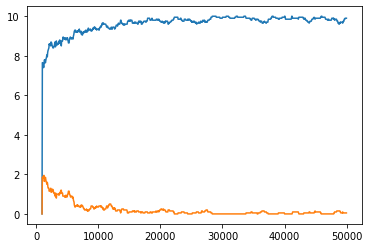

In [ ]:
Q = learn(50_000, plot=True, nbplot_points=1000, nbplot=10, plot_sma_len=20)

### Trained player 1 against random player 2

In [ ]:
# Joueur 1 entrainé contre j2 aléatoire
test_policy(Q, 5_000, verbose=True)


/usr/local/lib/python3.7/dist-packages/pettingzoo/utils/wrappers/base.py:52: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn("The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.")


The first player wins 98.61999999999999 % of the time, the second player wins 0.0 % of the time, and the game is a draw 1.38 % of the time.
Total : 99.99999999999999 %


{'player_1': 4931.0, 'player_2': 0.0}

In [ ]:
test_policy(Q, 50_000, verbose=True)

/usr/local/lib/python3.7/dist-packages/pettingzoo/utils/wrappers/base.py:52: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn("The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.")


The first player wins 98.662 % of the time, the second player wins 0.0 % of the time, and the game is a draw 1.3379999999999999 % of the time.
Total : 100.0 %


{'player_1': 49331.0, 'player_2': 0.0}

### Trained vs trained

In [ ]:
test_policy(Q, 5_000, verbose=True, players_type={'player_1' : 'Q', 'player_2' : 'Q'})

/usr/local/lib/python3.7/dist-packages/pettingzoo/utils/wrappers/base.py:52: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn("The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.")


The first player wins 100.0 % of the time, the second player wins 0.0 % of the time, and the game is a draw 0.0 % of the time.
Total : 100.0 %


{'player_1': 5000.0, 'player_2': 0.0}

In [ ]:
test_policy(Q, 2, verbose=True, players_type={'player_1' : 'Q', 'player_2' : 'Q'}, render=True)

-= Game 1 =-
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  X  |  -  |  -  
     |     |     

     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  O  
_____|_____|_____
     |     |     
  X  |  -  |  -  
     |     |     

     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  X  |  O  
_____|_____|_____
     |     |     
  X  |  -  |  -  
     |     |     

     |     |     
  -  |  -  |  O  
_____|_____|_____
     |     |     
  -  |  X  |  O  
_____|_____|_____
     |     |     
  X  |  -  |  -  
     |     |     

     |     |     
  -  |  -  |  O  
_____|_____|_____
     |     |     
  -  |  X  |  O  
_____|_____|_____
     |     |     
  X  |  -  |  X  
     |     |     

     |     |     
  O  |  -  |  O  
_____|_____|_____
     |     |     
  -  |  X  |  O  
_____|_____|_____
     |     |     
  X  |  -  |  X  
     |     |     

     |   

/usr/local/lib/python3.7/dist-packages/pettingzoo/utils/wrappers/base.py:52: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn("The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.")


{'player_1': 2.0, 'player_2': 0.0}

### Random vs trained

In [ ]:
test_policy(Q, 5_000, verbose=True, players_type={'player_1' : 'random', 'player_2' : 'Q'})

/usr/local/lib/python3.7/dist-packages/pettingzoo/utils/wrappers/base.py:52: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn("The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.")


The first player wins 0.6 % of the time, the second player wins 85.44 % of the time, and the game is a draw 13.96 % of the time.
Total : 100.0 %


{'player_1': 30.0, 'player_2': 4272.0}

## Analyses supplémentaires

### Learning against random

mkdir: cannot create directory ‘cached’: File exists
Fullrun


/usr/local/lib/python3.7/dist-packages/pettingzoo/utils/wrappers/base.py:52: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn("The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.")


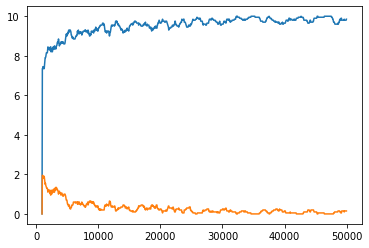

In [ ]:
Q_rand = learn(budget = 50_000, plot=True, players_type={'player_1' : 'Q', 'player_2' : 'random'},nbplot_points=1000, nbplot=10, plot_sma_len=20)

mkdir: cannot create directory ‘cached’: File exists
Fullrun


/usr/local/lib/python3.7/dist-packages/pettingzoo/utils/wrappers/base.py:52: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn("The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.")


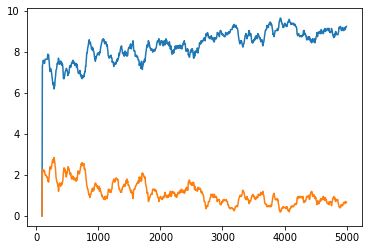

In [ ]:
_ = learn(5_000, plot=True, nbplot=10, nbplot_points=1000, players_type={'player_1' : 'Q', 'player_2' : 'random'}, plot_sma_len=20)

#### Test against trained agent

In [ ]:
test_policy({'player_1' : Q_rand['player_1'], 'player_2' : Q['player_2']}, 5_000, verbose=True, players_type={'player_1' : 'Q', 'player_2' : 'Q'})

/usr/local/lib/python3.7/dist-packages/pettingzoo/utils/wrappers/base.py:52: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn("The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.")


The first player wins 0.0 % of the time, the second player wins 0.0 % of the time, and the game is a draw 100.0 % of the time.
Total : 100.0 %


{'player_1': 0.0, 'player_2': 0.0}

In [ ]:
test_policy(Q_rand, 5_000, verbose=True, players_type={'player_1' : 'Q', 'player_2' : 'random'})

/usr/local/lib/python3.7/dist-packages/pettingzoo/utils/wrappers/base.py:52: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn("The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.")


The first player wins 98.61999999999999 % of the time, the second player wins 0.0 % of the time, and the game is a draw 1.38 % of the time.
Total : 99.99999999999999 %


{'player_1': 4931.0, 'player_2': 0.0}

## License

The code in this notebook is copyrighted by Gertjan Verhoeven and licensed under the new BSD (3-clause) license:

https://opensource.org/licenses/BSD-3-Clause

The text and figures in this notebook (if any) are copyrighted by Gertjan Verhoeven and licensed under the CC BY-NC 4.0 license:

https://creativecommons.org/licenses/by-nc/4.0/